### Methods to do:
1. Spectral processing:
    - TIC normalization
        * peak-picking doesn't perform on TIC norm... 
    - baseline correction(with median filtering ?)\
        * existing baseline correction reduces the number of peaks
    - peak-picking with 
        * S/N threshold 5
        * SNR ? 
    - recalibrate each spectrum using a <span style="color:magenta">linear best fit model</span> and
    then bin corresponding peaks across all spectra in the
    dataset to <span style="color:magenta">a common m/z</span>.
2. Ion-image standardization: 
    - The ion images  are individually <span style="color:red">winsorized</span> and then standardized
to a common range prior to clustering. 
        * <span style="color:red">Winsorizing</span> is a well-known robust stati stical estimation
technique which limits extreme values to reduce the effect
of potenti al outliers. Winsorizing involves clipping
extreme values, usually symmetrically on both extremities
of a distribution, before computing location statistic(s) of
interest such as the mean. In our case, we only winsorized
above the <span style="color:lime">95th percentile</span> to reduce the impact of high
intensity outliers commonly found in MSI data. Winsorizing
the lower extremity is not necessary for spectral data since
there is an explicit limit at 0 intensity. After winsorizing,
the resulting pixel intensities for each image are scaled to
the range <span style="color:lime">[0, 1]</span>. The resulting preprocessed images will
henceforth be referred to as regular ion images, and serve as
input for the next stage of the pipeline.

### Hang Paper:
two methods to perform UMAP:
1. Resampling 
    - Each spectrum was upsampled to 200,000 data points in the mass range of 135 – 1000 using linear interpolation.
2. Peak detection and m/z binning:
    - Representative line scan (x asis/y asis all spectra?) was selected. 
    - All spectra in the line were up-sampled to 8,000,000 data points with equally spaced m/z bins in the mass range of 135-1000.  
    - Avg. spectrum of the line. 
    - peak-picking on that(No filtering was used in this step in order to retain the original spectral information including noise).
    - a 10 ppm bin width was used to cluster(how ?) the observed peaks into mass bins.
    
for PCA: 
1. a representative line scan(x/y) was selected and avg spectra(two) was generated for both on and off-tissue(which we don't have ?).
2. extracted peaks from the two spectra with a relative intensity range of <span style="color:orange">0.5% - 100%</span> using Xcalibur software(don't know/have).
3. 
4. 
5. Finally ion-images were selected visually...<br>
suggestion:
    - raise the SNR threshold. Higher SNR peaks generate less noisy images.
    - then generate images for all peaks and select peaks if they have reasonable distributions.

1e-05

In [116]:
from msalign import msalign
msalignfolder = r'C:\Users\ranab\PycharmProjects\spinalcordinjury\msalign\example_data'
filename = glob(os.path.join(msalignfolder, '*.csv'))[0]
print(filename)
# data = np.genfromtxt(filename, delimiter=",")
data = np.genfromtxt(filename, delimiter=",")
x = data[1:, 0]
print("x", x.shape)
array = data[1:, 1:].T
print("array", array.shape)
peaks = [3991.4, 4598, 7964, 9160]
weights = [60, 100, 60, 100]

# instantiate aligner object
aligner = Aligner(
    x, 
    array, 
    peaks, 
    weights=weights,
    return_shifts=True,
    align_by_index=True,
    only_shift=True,
    method="pchip",
)
aligner.run()
aligned_array = aligner.align()
print(aligned_array.shape)
# peaks = [3991.4, 4598, 7964, 9160]
aligned = msalign(x, array, peaks, weights=[60, 100, 60, 100], only_shift=False) 
# aligned1 = msalign(x, array, peaks, weights=[100, 1, 1, 1], only_shift=False) 

C:\Users\ranab\PycharmProjects\spinalcordinjury\msalign\example_data\msalign_test_data.csv
x (15154,)
array (8, 15154)


AttributeError: 'NoneType' object has no attribute 'shape'

In [31]:
aligned.shape

(8, 15154)

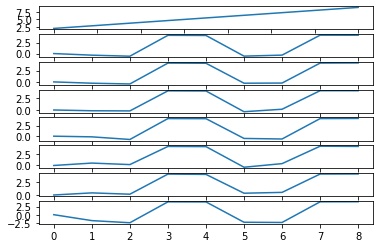

In [43]:
fig, ax = plt.subplots(aligned.shape[0])
axes = ax.ravel()
for i in range(aligned.shape[0]):
    axes[i].plot(data[i, :])
#     axes[i].set_xlim(1980, 5000)
# plt.show()

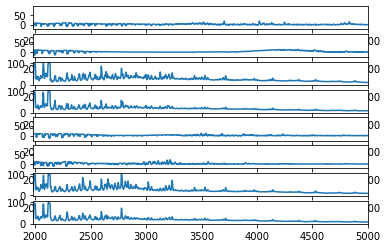

In [40]:
fig, ax = plt.subplots(aligned1.shape[0])
axes = ax.ravel()
for i in range(aligned1.shape[0]):
    axes[i].plot(aligned1[i, :])
    axes[i].set(xlim=(1980, 5000))
plt.show()

In [3]:
# !pip install matchms
import h5py
import os
from glob import glob
import copy
import math
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
import sys
sys.path.append("../matchms/")
from Utilities import ImzmlAll, normalize_spectrum
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ms_peak_picker import pick_peaks
from tqdm import tqdm

In [62]:
def baseline_als_optimized(y, lam=105, p=1e-3, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
#     print(w)
#     z[z<0]=0
    z_ = copy.deepcopy(z)
    z_[z_>0]=0
    z += abs(z_)
    return z

def _find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")  # Find indices
    if idx > 0 and (
            idx == len(array)
            or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])
    ):
        return idx - 1
    else:
        return idx
    
def peak_pick(refmz, spectra):
    """
    spectra: 2D array of spectra -> nSpec x nMZ
    meanSpec: mean abundance/intensity of all regions
    by peak_picking ...
    """
    picking_method = "quadratic"
    snr = 10   #3 # standard: lower value increases number of peaks
    intensity_threshold = 5    #5 # depends on instrument/ 0 -> more permissive
    fwhm_expansion = 2 # 1.4    # shouldn't be more than 2; 1.2 - 1.4 is optimum
#     if meanSpec is None: #spectra.ndim == 2:
#         meanSpec = np.mean(spectra, axis=0)
    # else:   # if mean of all regions given...
    #     meanSpec = spectra
    peak_list = pick_peaks(refmz,
                           spectra,
                           fit_type=picking_method,
                           signal_to_noise_threshold=snr,
                           intensity_threshold=intensity_threshold,
                           integrate=False)
    peak_mzs = [np.round(p.mz, 5) for p in peak_list]   # only for visualisation
    peak_ranges = [
        (p.mz - (p.full_width_at_half_max * fwhm_expansion),
         p.mz + (p.full_width_at_half_max * fwhm_expansion),
        )
        for p in peak_list]
    # print("peak ranges", peak_ranges)
    peak_indices = [
        (_find_nearest(refmz, p[0]), _find_nearest(refmz, p[1])) for p in peak_ranges
    ]
#     spectra_ = []
#     for spectrum in spectra:
    peaks = []
    for p in peak_indices:
        peaks.append(np.sum(spectra[p[0]: p[1]]))
#         spectra_.append(peaks)
    spectra = np.array(peaks, dtype=np.float32)
    return spectra, peak_mzs

In [3]:
# path = glob(os.path.join(r'C:\Data\210427-Chen_poslip', '*.h5'))[0]
mspath = glob(os.path.join(r'C:\Data\210427-Chen_poslip', '*.imzML'))[0]

In [4]:
ImzObj = ImzmlAll(mspath)
regID = 1

C:\Users\ranab\Miniconda3\envs\ims37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


In [13]:
def findValInd(_list, func=max):
    """
    :param _list: the list 
    :param func: max default, min or so
    :return: value and index
    """
    _value = func(_list)
    _index = _list.index(_value)
    return _value, _index

In [49]:
regDir = r'C:\Data\210427-Chen_poslip\reg_1'
resampledpath = os.path.join(regDir, 'resampled_reg_1_tol_0.01.h5')
with h5py.File(resampledpath, 'r') as pFile:
    print(pFile.keys())
    spectra = np.array(pFile.get('spectra'))
    mzrange = np.array(pFile.get('mzrange'))
    
print(spectra.shape, mzrange.shape)

<KeysViewHDF5 ['coordinates', 'mzrange', 'regionshape', 'spectra']>
(3142, 149315) (149315,)


In [89]:
np.random.seed(306)
arr = np.random.randint(0, 10, 6)
print(arr)
arr_sort = arr[np.argsort(arr)]
print(arr_sort)

arr_max_idx =  arr.argsort()[-2:][::-1]
print(arr1)

[0 1 9 1 9 4]
[0 1 1 4 9 9]
[4 2]


In [ ]:
def getmaxIdx(array, n):
    """
    get indices of highest n elements in array
    """
    return array.argsort()[-n:][::-1]

meanspec = np.mean(spectra, axis=0) 
# plt.plot()
# plt.show()
# meanspec_sort = meanspec[np.argsort(meanspec)]
# print(meanspec_sort)
# print(meanspec_sort[1], type(meanspec_sort))

# print(meanspec[np.where(meanspec == meanspec_sort[1])])
# meanspec[meanspec_sort[-1]] == max(meanspec)
# print(meanspec_sort[-3:]) 


In [104]:
from msalign import Aligner

In [113]:
# peaks = getmaxIdx(meanspec, 10)
x = spectra[0, :]
print(x.shape, "x")
weights = np.ones_like(peaks)
array = spectra[1:25].T
print(array.shape)

(149315,) x
(149315, 24)


In [114]:
aligner = Aligner(
    x, 
    array, 
    peaks, 
    weights=weights,
    return_shifts=True,
    align_by_index=True,
    only_shift=False,
    method="pchip",
)
aligner.run()
aligned_array, shifts_out = aligner.align()

C:\Users\ranab\Miniconda3\envs\ims37\lib\site-packages\msalign\utilities.py:106: UserWarning: The input array was rotated to match the x-axis input
  warnings.warn("The input array was rotated to match the x-axis input", UserWarning)


TypeError: cannot unpack non-iterable NoneType object

In [102]:
getmaxIdx(meanspec, 10)

array([25375, 25376, 25374, 25475, 28178, 29170, 29171, 25476, 27573,
       10444], dtype=int64)

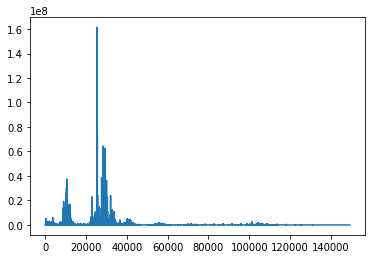

In [62]:
plt.plot(meanspec)

In [49]:
np.random.randint()

NameError: name '_list' is not defined

In [27]:
findValInd(ImzObj.parser.mzLengths)
(minx, maxx), (miny, maxy), (minz, maxz), spectralength, mzidx = ImzObj.get_region_range(1)

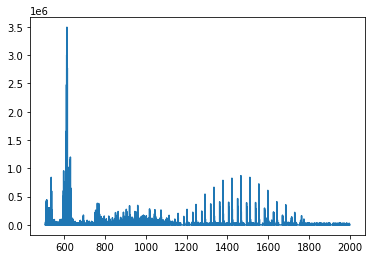

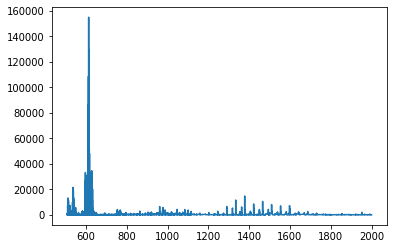

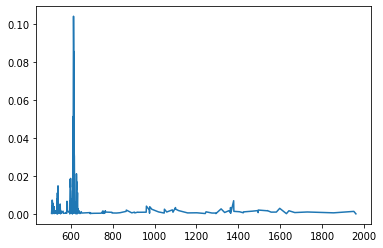

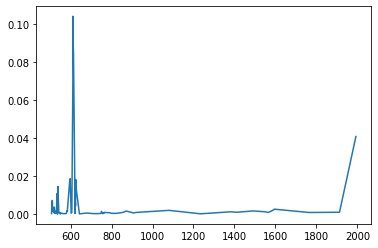

171


In [63]:
# regID = 1
# gcoord2index = ImzObj._global2index()
# regionPixels = ImzObj.get_region_pixels(regID)
# peaklen = []

# for idx, coord in enumerate(tqdm(regionPixels, desc='binning')):
# mz, spec = ImzObj.parser.getspectrum(sIdx) #gcoord2index[coord])
# spec_bc = baseline_als_optimized(spec)
# peakspec, peakmzs = peak_pick(mz, spec_bc)
# peakspec_tic = normalize_spectrum(peakspec, 'tic')
# ImzObj._interpolate_spectrum(peakspec_tic, peakmzs, )
# peaklen.append(len(peakmzs))
# print(max(peaklen), "is the max bin of peaks in reg {}".format(regID))

def pickcommonmz(Imzobj, func):
#     peaklen = []
#     for sIdx in range(len(Imzobj.parser.coordinates)):
    _list = Imzobj.parser.mzLengths
    if func == 'max':
        _value = max(_list)
        _index = _list.index(_value)
    elif func == 'min':
        _value = min(_list)
        _index = _list.index(_value)
    elif func == 'med':
        _value = int(np.median(_list))
        _index = _list.index(_value)
    else: # random
        pass
    mz, spec = ImzObj.parser.getspectrum(_index)
    spec_bc = baseline_als_optimized(spec)
    peakspec, peakmzs = peak_pick(mz, spec_bc)
#     peakspec_tic = normalize_spectrum(peakspec, 'tic')
#         peaklen.append(len(peakmzs))
    return peakmzs, len(peakmzs)

maxpeakmzs, lenmzs = pickcommonmz(ImzObj, 'med')

sIdx = 153
mz, spec = ImzObj.parser.getspectrum(sIdx) #gcoord2index[coord])
spec_bc = baseline_als_optimized(spec)
peakspec, peakmzs = peak_pick(mz, spec_bc)
peakspec_tic = normalize_spectrum(peakspec, 'tic')
spec_int = ImzObj._interpolate_spectrum(peakspec_tic, peakmzs, maxpeakmzs)

plt.plot(ImzObj.parser.getspectrum(sIdx)[0], ImzObj.parser.getspectrum(sIdx)[1])
plt.show()
plt.plot(mz, spec_bc)
plt.show()
plt.plot(peakmzs, peakspec_tic)
plt.show()
plt.plot(maxpeakmzs, spec_int)
plt.show()
print(len(maxpeakmzs))
# fig, ax = plt.subplots(2, 1, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
# labels = ['raw', 'back_corrected', 'peak_picked', 'tic_norm']
# ax[0].vlines(mz, [0], spec, color=(0.9, 0, 0), linewidth=1.5, label=labels[0])  # , alpha=0.9)
# ax[0].set_xlabel("m/z", fontsize=12)
# ax[0].set_ylabel("intensity", fontsize=12, color=(0.9, 0, 0))
# ax[0].legend(loc='upper center')
# ax[0].grid()
# ax0 = ax[0].twinx()
# ax0.vlines(mz, [0], spec_bc, color=(0, 0, 0.9), linewidth=1.5, label=labels[1], alpha=0.5)
# ax0.set_xlabel("m/z", fontsize=12)
# ax0.set_ylabel("intensity", fontsize=12, color=(0, 0, 0.9))
# ax0.legend(loc='upper right')
# # ax[1].set_xtick()
# # ax.grid()

# ax[1].vlines(peakmzs, [0], peakspec, color=(0.9, 0, 0), linewidth=1.5, label=labels[2])  # , alpha=0.9)
# ax[1].set_xlabel("m/z", fontsize=12)
# ax[1].set_ylabel("intensity", fontsize=12, color=(0.9, 0, 0))
# ax[1].legend(loc='upper center')
# ax[1].grid()
# ax1 = ax[1].twinx()
# ax1.vlines(peakmzs, [0], peakspec_tic, color=(0, 0, 0.9), linewidth=1.5, label=labels[3], alpha=0.5)
# ax1.set_xlabel("m/z", fontsize=12)
# ax1.set_ylabel("intensity", fontsize=12, color=(0, 0, 0.9))
# ax1.legend(loc='upper right')
# # ax[3].grid()

# # plt.plot(mz, spec)
# # plt.show()
# # plt.plot(mz, spec_bc)
# # plt.show()
# # plt.plot(peakmzs, peakspec)
# # plt.show()
# # plt.scatter(peakmzs, peakspec_tic, marker='.', c='r')
# # plt.show()
# print(len(peakmzs), peakmzs)

In [29]:
pmzs, nmzs = pre_processing(ImzObj, mzidx)

In [6]:
spec_tic_bc = baseline_als_optimized(spec_tic)

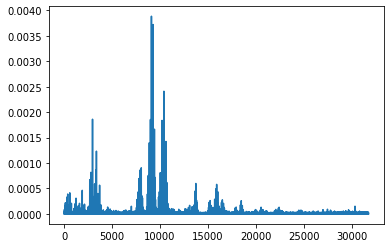

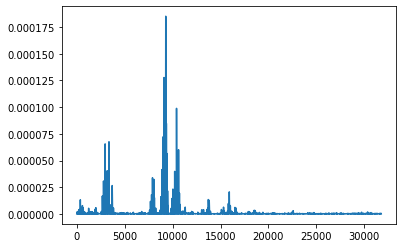

In [7]:
plt.plot(spec_tic)
plt.show()
plt.plot(spec_tic_bc)
plt.show()

In [8]:
print(spec_tic.shape, spec_tic_bc.shape)

(31769,) (31769,)


In [15]:
# print(type(spec_tic_bc), type(list(mz)))
# print(len(spec_tic_bc), len(mz))
print(len(spec_tic_bc) == len(mz))

True


In [39]:
spec_tic_bc.shape, mz.shape

((31769,), (31769,))

In [47]:
mz, spec = ImzObj.parser.getspectrum(122)

In [55]:
peak_spec, peak_mz = peak_pick(mz, spec)

In [56]:
print(peak_spec.shape)

(1576,)


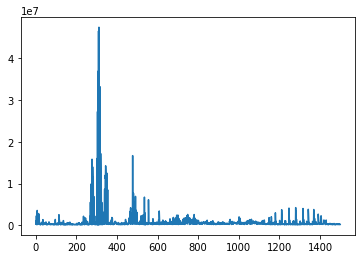

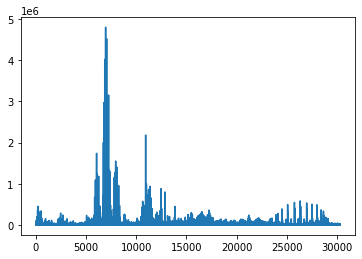

In [50]:
plt.plot(peak_spec)
plt.show()
plt.plot(spec)
plt.show()

In [119]:
# plt.plot(spec_tic_bc[nzInd])
print(nzInd)

(array([   75,    76,    77, ..., 29706, 29707, 29708], dtype=int64),)


In [89]:
spec_tic_bc = baselineCorrection(mz, spec_tic)

C:\Users\ranab\Miniconda3\envs\ims37\lib\site-packages\numpy\polynomial\polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


C:\Users\ranab\Miniconda3\envs\ims37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


No previous upsampling found. Performing...


binning:  35%|███▍      | 1097/3142 [06:53<11:41,  2.92it/s]

Plotting: #1097


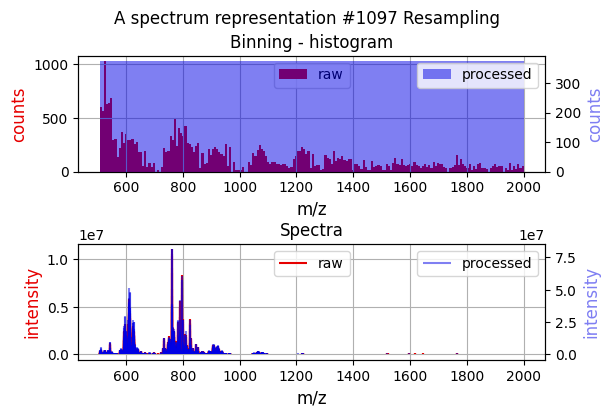

binning: 100%|██████████| 3142/3142 [21:06<00:00,  2.48it/s]  


saving resampled data...


In [3]:
# ImzObj = ImzmlAll(mspath)
# regID = 1
# spectra, refmz, regionshape, localCoor = ImzObj.resample_region(regID, tol=0.02, savedata=True)
# peakspectra, peakmzs = ImzObj.peak_pick(spectra, refmz)

In [24]:
print(spectra.shape, len(refmz))
print(peakspectra.shape, len(peakmzs))

(3142, 74658) 74658
(3142, 3529) 3529


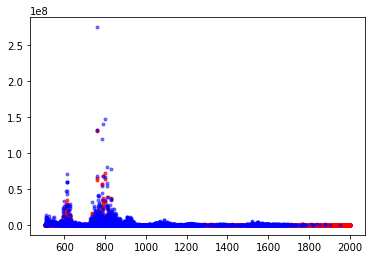

In [22]:
plt.scatter(refmz, spectra[31,:], c='r', marker='.', alpha=0.7)
plt.scatter(peakmzs, peakspectra[31,:], c='b',marker='.', alpha=0.5)

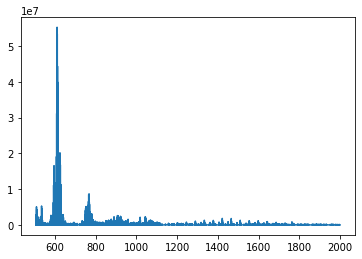

In [20]:
plt.plot(np.array(refmz), spectra[3000,:])

In [22]:
from sklearn.preprocessing import StandardScaler
from Utilities import msmlfunc6

In [23]:
def _2d_to_3d(array2d, Coord, regionshape):
    nPixels, nMz = array2d.shape
    array3d = np.zeros([regionshape[0], regionshape[1], nMz])
    for idx, c in enumerate(Coord):
        array3d[c[0], c[1], :] = array2d[idx, :]
    return array3d

In [24]:
images = _2d_to_3d(peakspectra, localCoor, regionshape)

In [25]:
images.shape

(84, 48, 1157)

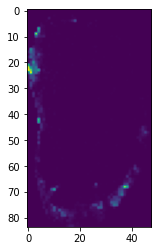

In [31]:
plt.imshow(images[..., 1156])

In [33]:
SS = StandardScaler()

In [34]:
peakspectra_ss = SS.fit_transform(peakspectra)

In [49]:
peakspectra_t_ss = SS.fit_transform(peakspectra.T).T
print(np.mean(peakspectra_t_ss), np.std(peakspectra_t_ss))

-7.975063e-11 0.9999998


In [35]:
print(np.mean(peakspectra_ss), np.std(peakspectra_ss))

6.1785754e-09 1.0


In [66]:
images_flat = images.reshape((-1, images.shape[2]))
print(images_flat.shape)
# images_ss_flat = images_ss.reshape((-1, images_ss.shape[2]))
# images_t_ss_flat = images_t_ss.reshape((-1, images_t_ss.shape[2]))

(4032, 1157)


In [70]:
pixel_ss = SS.fit_transform(images_flat)
pixel_t_ss = SS.fit_transform(images_flat.T).T
print(pixel_ss.shape, pixel_t_ss.shape)
print(np.mean(pixel_ss), np.std(pixel_ss))
print(np.mean(pixel_t_ss), np.std(pixel_t_ss))

(4032, 1157) (4032, 1157)
-4.094167304869491e-18 0.9999999999999986
3.046255435170752e-20 0.8827603712309887


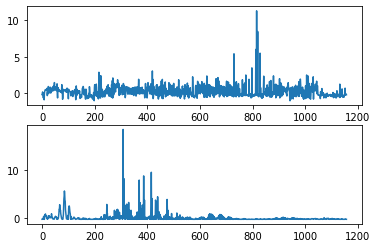

In [76]:
p = 1000
plt.subplot(211)
plt.plot(pixel_ss[p, :])
plt.subplot(212)
plt.plot(pixel_t_ss[p,:])
# plt.subplot(313)
# plt.plot(peakspectra_t_ss[p,:])

In [82]:
regionshape = np.array(regionshape)
print(regionshape)

[84 48]


In [102]:
images_ss = pixel_ss.reshape((regionshape[0], regionshape[1], pixel_ss.shape[1])) #_2d_to_3d(peakspectra_ss, localCoor, regionshape)
images_t_ss = pixel_t_ss.reshape((regionshape[0], regionshape[1], pixel_t_ss.shape[1]))

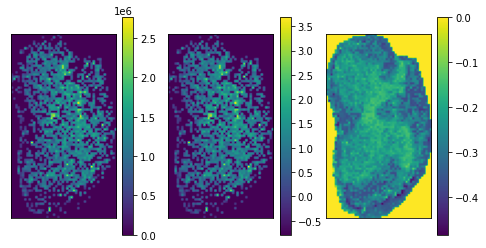

(1157, 4032)


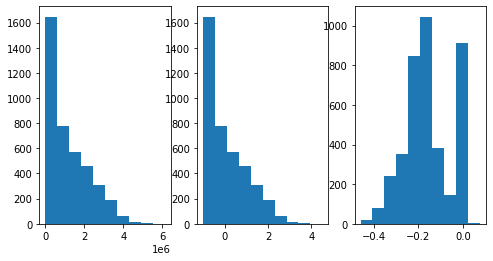

(4032, 1157)


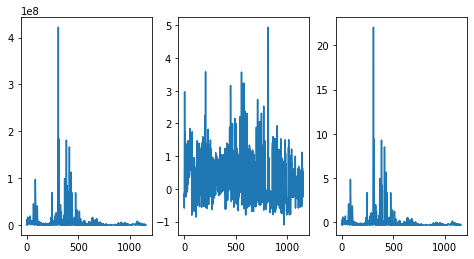

In [126]:
m = 500
plt.figure(figsize=(8,4))       # set dimensions of the figure
imgList = [images, images_ss, images_t_ss]
for i in range(1,4):
    plt.subplot(1,3, i)         # create subplots on a grid with 2 rows and 3 columns
    plt.xticks([])              # set no ticks on x-axis
    plt.yticks([])              # set no ticks on y-axis
    plt.imshow(imgList[i-1][..., m])
    plt.colorbar()
#     plt.title('subplot' + '(2,3,' + str(i) + ')')
plt.show()

p = 500
plt.figure(figsize=(8,4))       # set dimensions of the figure
imgfList = [i.reshape((-1, i.shape[2])).T for i in imgList]
print(imgfList[1].shape)
for i in range(1,4):
    plt.subplot(1,3, i)         # create subplots on a grid with 2 rows and 3 columns
#     plt.xticks([])              # set no ticks on x-axis
#     plt.yticks([])              # set no ticks on y-axis
    plt.hist(imgfList[i-1][p])
#     plt.colorbar()
#     plt.title('subplot' + '(2,3,' + str(i) + ')')
plt.show()

p = 2000
plt.figure(figsize=(8,4))       # set dimensions of the figure
imgfList = [i.reshape((-1, i.shape[2])) for i in imgList]
print(imgfList[1].shape)
for i in range(1,4):
    plt.subplot(1,3, i)         # create subplots on a grid with 2 rows and 3 columns
#     plt.xticks([])              # set no ticks on x-axis
#     plt.yticks([])              # set no ticks on y-axis
    plt.plot(imgfList[i-1][p])
#     plt.colorbar()
#     plt.title('subplot' + '(2,3,' + str(i) + ')')
plt.show()

In [113]:
print(images_ss.shape)

(84, 48, 1157)


In [128]:
RandomState = 20210131
pca_all=PCA(random_state=RandomState) 
pcs_all=pca_all.fit_transform(pixel_ss) 

In [129]:
pcs_all.shape

(4032, 1157)

In [51]:

import numpy as np
from numpy.linalg import norm

def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)
    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)
    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    crit = 1
    count = 0
    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))
        crit = norm(w_new - w) / norm(w)
        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values
        count += 1
        if count > niter:
            print('Maximum number of iterations exceeded')
            break
    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z
    
def baseline_als(y, p=0.01, lam=100, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = linalg.spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z



In [56]:
y = ImzObj.parser.getspectrum(120)[1]

In [57]:
z = baseline_als_optimized(y)

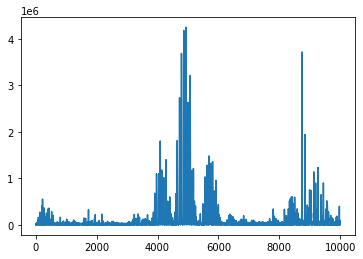

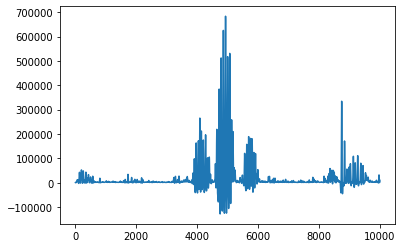

In [60]:
plt.plot(y[0:10000])
plt.show()
plt.plot(z[0:10000])
plt.show()


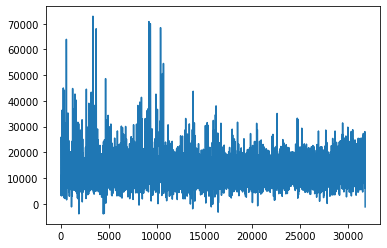

In [35]:
plt.plot(z)

In [45]:
print(ImzObj.parser.getspectrum(12))

(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1998.81689453,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 3708.76293945, ...,    0.        ,
          0.        ,    0.        ]))


In [92]:
from scipy.io import savemat
from collections import defaultdict
import pickle

In [94]:
regname = os.path.join(r'C:\Users\ranab\Documents\MATLAB', 'poslip_spec.bin')
# matr = {"mz": ImzObj.parser.getspectrum(12)[0], 
#         "spec": ImzObj.parser.getspectrum(12)[1]}
specIdx = [1, 11, 101, 1001]
rawspectra = defaultdict(list)
for s in specIdx:
    rawspectra[s].append(ImzObj.parser.getspectrum(s))
print(rawspectra)
# savemat(regname, rawspectra) 
with open(regname, 'wb') as pfile:
    pickle.dump(rawspectra, pfile)

defaultdict(<class 'list'>, {1: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1998.14807129,
       1999.97509766, 1999.98266602]), array([    0.        ,     0.        , 13475.50390625, ...,
           0.        ,     0.        , 31814.42773438]))], 11: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.07250977,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 6485.21289062, ...,    0.        ,
          0.        ,    0.        ]))], 101: [(array([ 506.83822632,  506.93829346,  506.93878174, ..., 1996.75927734,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 4751.94824219, ...,    0.        ,
          0.        ,    0.        ]))], 1001: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.01989746,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 8969.41113281, ...,    0.        ,
          0.        ,    0.        ]))]})


defaultdict(<class 'list'>, {1: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1998.14807129,
       1999.97509766, 1999.98266602]), array([    0.        ,     0.        , 13475.50390625, ...,
           0.        ,     0.        , 31814.42773438]))], 11: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.07250977,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 6485.21289062, ...,    0.        ,
          0.        ,    0.        ]))], 101: [(array([ 506.83822632,  506.93829346,  506.93878174, ..., 1996.75927734,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 4751.94824219, ...,    0.        ,
          0.        ,    0.        ]))], 1001: [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.01989746,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 8969.41113281, ...,    0.        ,
          0.        ,    0.        ]))]})


In [67]:
print(rawspectra.keys())

dict_keys([1, 11, 101, 1001])


In [75]:
rawspectra[11][0][1]

array([   0.        ,    0.        , 6485.21289062, ...,    0.        ,
          0.        ,    0.        ])

In [82]:
for name, var in rawspectra.items():
    print(name, var)

1 [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1998.14807129,
       1999.97509766, 1999.98266602]), array([    0.        ,     0.        , 13475.50390625, ...,
           0.        ,     0.        , 31814.42773438]))]
11 [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.07250977,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 6485.21289062, ...,    0.        ,
          0.        ,    0.        ]))]
101 [(array([ 506.83822632,  506.93829346,  506.93878174, ..., 1996.75927734,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 4751.94824219, ...,    0.        ,
          0.        ,    0.        ]))]
1001 [(array([ 506.83822632,  507.22860718,  507.22909546, ..., 1999.01989746,
       1999.97509766, 1999.98266602]), array([   0.        ,    0.        , 8969.41113281, ...,    0.        ,
          0.        ,    0.        ]))]


In [ ]:
from Utilities import normalize_spectrum